<a href="https://colab.research.google.com/github/GiaLop/Python-Projects/blob/main/Disastri_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Requirements

Install following packages and dataset:

!wget https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip <br>
!unzip ne_110m_admin_0_countries.zip -d ne_countries <br>
!pip install geopandas cartopy <br>
!pip install geodatasets <br>
!pip install pycountry <br>


In [ ]:
# Importing necessaries libraries
import os
from datetime import datetime

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pycountry

%matplotlib inline

In [4]:
# Reading the data set
url = 'https://proai-datasets.s3.eu-west-3.amazonaws.com/aviation-accidents.csv'
disaster = pd.read_csv(url)

# Making a df copy to work with
disaster_c = disaster.copy()

# EDA:

In [ ]:
# A closer look to stats
display(disaster.head(5))
display(disaster.tail(5))
disaster.info()
disaster.columns

,date,type,registration,operator,fatalities,location,country,cat,year
0,date unk.,Antonov An-12B,T-1206,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
1,date unk.,Antonov An-12B,T-1204,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
2,date unk.,Antonov An-12B,T-1201,Indonesian AF,NaN,NaN,Unknown country,U1,unknown
3,date unk.,Antonov An-12BK,NaN,Soviet AF,NaN,Tiksi Airport (IKS),Russia,A1,unknown
4,date unk.,Antonov An-12BP,CCCP-11815,Soviet AF,0,Massawa Airport ...,Eritrea,A1,unknown


,date,type,registration,operator,fatalities,location,country,cat,year
23962,11-MAY-2023,Hawker 900XP,PK-LRU,Angkasa Super Services,0,Maleo Airport (MOH),Indonesia,A2,2023
23963,11-MAY-2023,Cessna 208B Grand Caravan,PK-NGA,Nasional Global Aviasi,0,Fentheik Airstrip,Indonesia,A2,2023
23964,12-MAY-2023,Cessna 208B Grand Caravan,5X-RBR,Bar Aviation,0,Kampala-Kajjansi...,Uganda,A1,2023
23965,14-MAY-2023,Boeing 747-4R7F,LX-OCV,Cargolux,0,Luxembourg-Finde...,Luxembourg,A2,2023
23966,15-MAY-2023,Learjet 35A,D-CGFQ,GFD,2,Hohn Air Base,Germany,A1,2023


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23967 entries, 0 to 23966
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          23967 non-null  object
 1   type          23967 non-null  object
 2   registration  22419 non-null  object
 3   operator      23963 non-null  object
 4   fatalities    20029 non-null  object
 5   location      23019 non-null  object
 6   country       23967 non-null  object
 7   cat           23967 non-null  object
 8   year          23967 non-null  object
dtypes: object(9)
memory usage: 1.6+ MB


Index(['date', 'type', 'registration', 'operator', 'fatalities', 'location',
       'country', 'cat', 'year'],
      dtype='object')

In [ ]:
# Displaying NaN and duplicates
display(disaster.isna().sum())
display(disaster.duplicated().sum())

,0
date,0
type,0
registration,1548
operator,4
fatalities,3938
location,948
country,0
cat,0
year,0


np.int64(115)

---------------------------------------------------------------------------------------------------------

## **Cleaning data, buildind a bar plot showing fatalities by year**

In [ ]:
# Managing NaN value

""" Try to convert str values in int, stripping and summing
    otherwise return NaN value"""

def clean_nan(x):

    if pd.isna(x):
        return np.nan
    # Converting in string, stripping spaces
    x_str = str(x).strip()
    # Finding plus in between number
    if '+' in x_str:
        try:
            # Splitting in '+', removing spaces form each str and converting in int
            parts = [int(p.strip()) for p in x_str.split('+')]
            return sum(parts)
        except ValueError:
            return np.nan
    # if not '+' in str convert in int
    try:
        return int(x_str)
    except ValueError:
        return np.nan

# Appling function to df column
disaster_c['fatalities'] = disaster_c['fatalities'].apply(clean_nan)

# Convert to numeric, coercing errors if not convertible
# (pd.to_numeric is fundamental to covert any str data in numeric type if dataset is read uncorrectly)
disaster_c['fatalities'] = pd.to_numeric(disaster_c['fatalities'], errors='coerce')

# Filling NaN fatalities with 0 after converting to numeric
disaster_c['fatalities'] = disaster_c['fatalities'].fillna(0)

# Converting 'year' column to pandas integer type, coercing errors
disaster_c['year'] = pd.to_numeric(disaster_c['year'], errors='coerce').astype('Int64')

# Dropping rows where 'year' could not be converted to a number
disaster_c = disaster_c.dropna(subset=['year'])

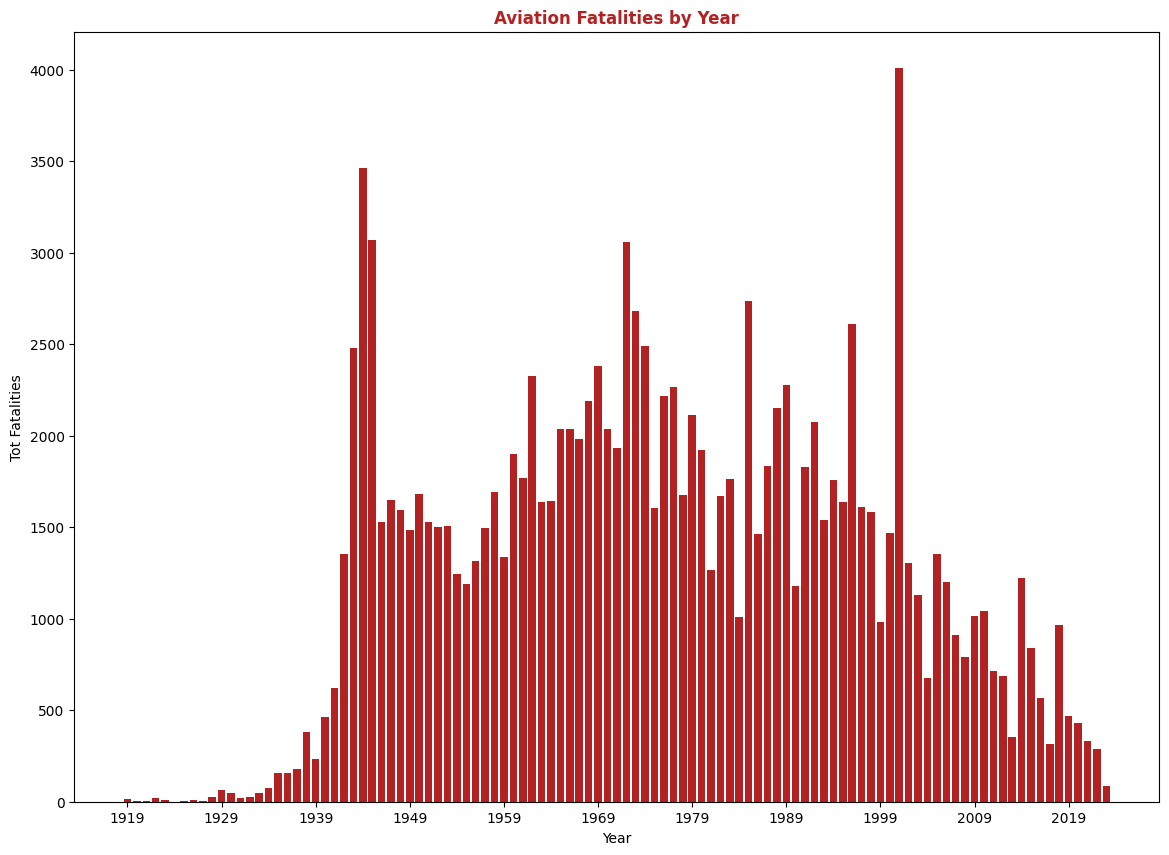

In [ ]:
# Groupping by year and sum fatalities
fatalities_by_year = disaster_c.groupby('year')['fatalities'].sum()

# Plotting the data
plt.rcParams['figure.figsize'] = [14, 10]
plt.bar(fatalities_by_year.index, fatalities_by_year.values, color='#b22222')
plt.title('Aviation Fatalities by Year', fontweight='bold', color='#b22222')
plt.xticks(np.arange(1919, 2023, 10))
plt.xlabel('Year')
plt.ylabel('Tot Fatalities')
plt.show()

# Observation:
We can see on the graph that the years with many fatalities are:
- early '40s during the WW2
- during the 70's beacuse of the wars in different countries such as in Vietnam
- 2001 the year of the Twin Towers tragedy

After the '00s fatalities begin ti decrease year by year

---------------------------------------------------------------------------------------------------------

## **Finding the safest operators flight company**

In [ ]:
# Managing with operator's NaN values

# Defining Boolean mask
mask = disaster_c['operator'].isna()

# Displaying NaN values in rows
display(disaster_c.loc[mask])

# Dropping row with NaN operator
disaster_c = disaster_c.drop(index=disaster_c.loc[mask].index)

,date,type,registration,operator,fatalities,location,country,cat,year
22071,10-MAR-2014,Learjet 35A,LV-ZSZ,NaN,0.0,"San Fernando, BA",Argentina,A2,2014
23326,16-NOV-2019,Bombardier CRJ-900,NaN,NaN,0.0,DÃ¼sseldorf Inte...,Germany,A2,2019
23853,31-AUG-2022,Cessna 208 Caravan,NaN,NaN,0.0,near Abu Dhabi-Bateen...,U.A.E.,A1,2022
23918,27-JAN-2023,Ilyushin Il-18D,TL-KBR,NaN,0.0,Al-Khadim Air Base,Libya,O1,2023


### I decided to drop 4 rows with NaN operator's values. There were 0 fatalities in each row so the were not influent for the total count.

### Showing a table with all the safest opeartors with 0.0 fatalities

In [ ]:
# Cleaning operator column data from symbols
disaster_c['operator_c'] = disaster_c['operator'].str.replace(r'[^a-zA-Z0-9]', '', regex=True).str.strip()
disaster_c['operator_c'] = disaster_c['operator_c'].str.replace('rzteflugambulanz', 'Arzteflugambulanz')

# Filtering for operators with zero fatalities and selecting specific columns
operator_by_fatalities = disaster_c.groupby('operator_c')['fatalities'].max()
safer_operator = operator_by_fatalities[operator_by_fatalities == 0.0]
display(safer_operator)

,fatalities
operator_c,
09Charlie,0.0
1982047LLC,0.0
2MLeasing,0.0
2ndArkhangelskUnitedAviationDivision,0.0
2ndSverdlovskAviationEnterprise,0.0
...,...
easyJet,0.0
easyJetEurope,0.0
easyJetSwitzerland,0.0


---------------------------------------------------------------------------------------------------------

## **Finding countries with most fatalities**

### In the grouped table I found some values in 'country' corresponding to '?'. <br> I will proceed to manage them.

In [ ]:
# Showing Country column with '?' values
disaster_unk_country = disaster_c.query("country == '?'").replace('?', 'Unk')
display(disaster_unk_country)

In [ ]:
# Groupping country by fatalities
accidents_by_country = disaster_c.groupby('country')['fatalities'].sum()

# Sorting values in discending
accidents_by_country = accidents_by_country.sort_values(ascending=False)

# Selecting first 10 countries
accidents_by_country = accidents_by_country.iloc[:10]
accidents_by_country

,fatalities
country,
USA,19305.0
Russia,9973.0
Brazil,3523.0
India,3505.0
France,3426.0
Indonesia,3360.0
Colombia,3325.0
Atlantic Ocean,2900.0
China,2870.0


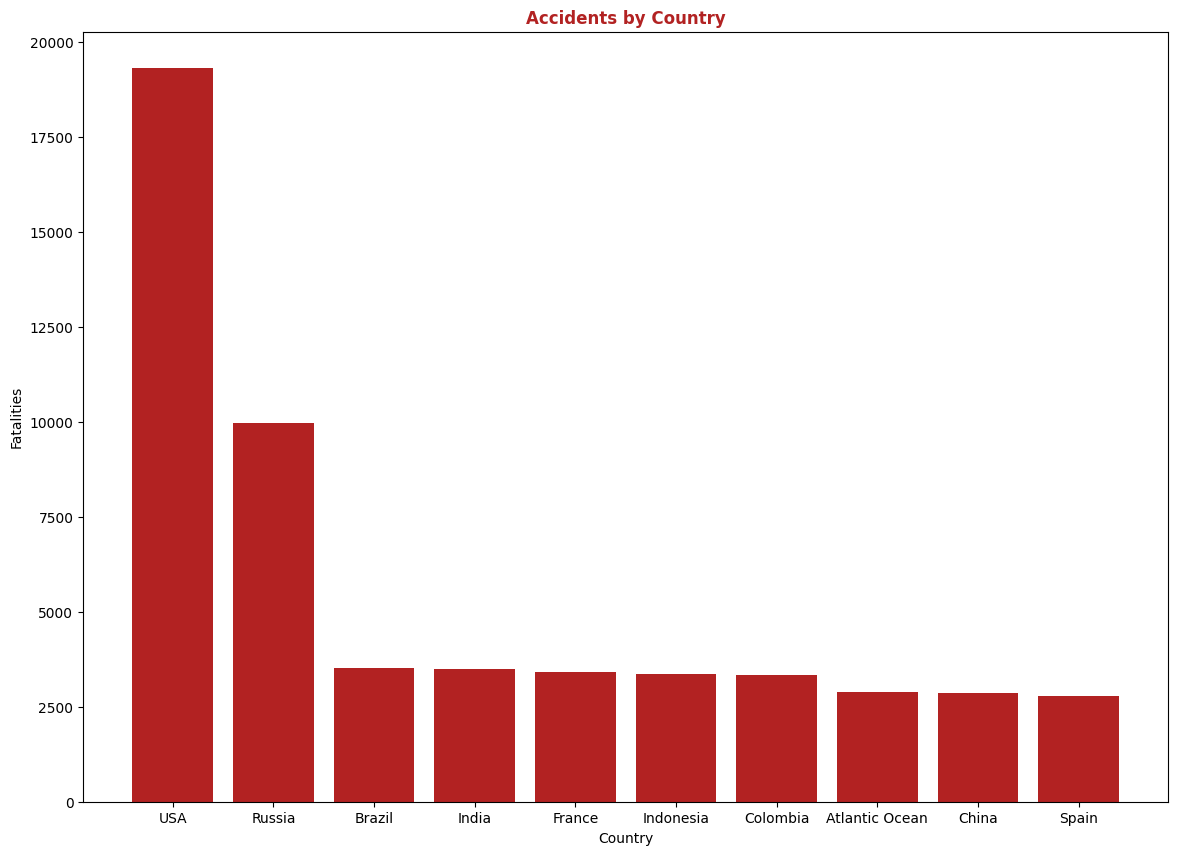

In [ ]:
# Plotting the data
plt.bar(accidents_by_country.index, accidents_by_country.values, color='#b22222')
plt.rcParams['figure.figsize'] = [14,10]
plt.xlabel('Country')
plt.ylabel('Fatalities')
plt.title('Accidents by Country', fontweight='bold', color='#b22222')
plt.show()

---------------------------------------------------------------------------------------------------------

## **On which day are there most fatalities?**

In [ ]:
# Setting data column in datetime
disaster_c['date'] = pd.to_datetime(disaster_c['date'], format = '%d-%b-%Y', errors='coerce')

# Extracting week's days
disaster_c['week_day'] = disaster_c['date'].dt.day_name()

# Groupping fatalities by weeks days
fatalities_by_day = disaster_c.groupby('week_day')['fatalities'].sum().sort_values(ascending=False)

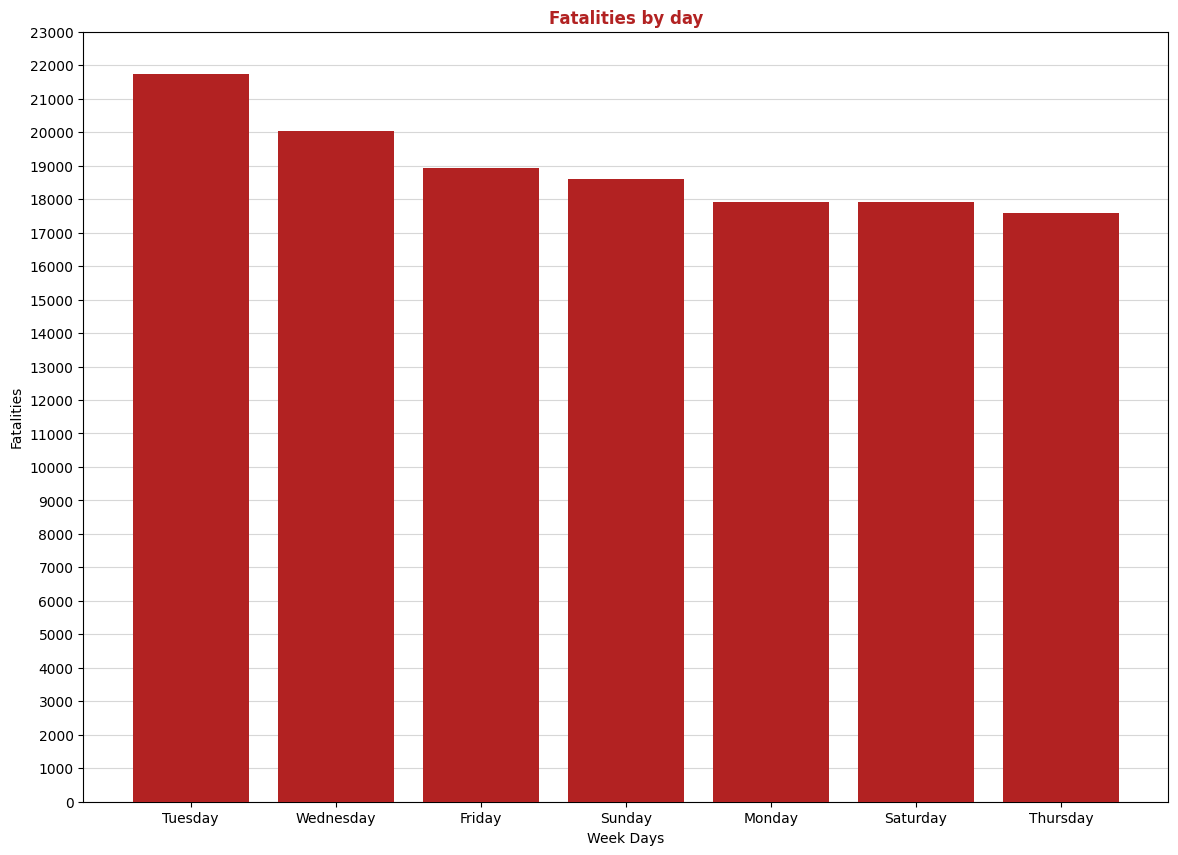

In [ ]:
# Plotting datas
plt.bar(fatalities_by_day.index, fatalities_by_day.values, color='#b22222', zorder=3)
plt.rcParams['figure.figsize'] = [14,10]
plt.title("Fatalities by day", fontweight='bold', color='#b22222')
plt.xlabel("Week Days")
plt.ylabel("Fatalities")
plt.yticks(np.arange(0, 24000, 1000))
plt.grid(axis='y', alpha=0.5, zorder=0)
plt.show()

# Observation:

From the max (Tuesday) to the min (Thursday) amount of fatalities there's not much difference, their almost evenly distribuited.

-----------------------------------------------------------------------------

## **What are the more dangerous aircraft types?**

In [ ]:
# Finding max value fatalities for aircraft type
aircraft_by_fatalities = disaster_c.groupby('type')['fatalities'].max().sort_values(ascending=False)

# Defining more dangerous aircraft from descending sorted rank
more_dangerous_aircraft = aircraft_by_fatalities.head(1)

# Displaing first value
display(more_dangerous_aircraft)

,fatalities
type,
Boeing 767-223ER,1692


-----------------------------------------------------------------------------

# **CREATING A CARTOGRAM**

In [ ]:
# Uploading geo dataset
world = gpd.read_file("ne_countries/ne_110m_admin_0_countries.shp")
display(world.columns)

Index(['featurecla', 'scalerank', 'LABELRANK', 'SOVEREIGNT', 'SOV_A3',
       'ADM0_DIF', 'LEVEL', 'TYPE', 'TLC', 'ADMIN',
       ...
       'FCLASS_TR', 'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT',
       'FCLASS_NL', 'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'geometry'],
      dtype='object', length=169)

In [ ]:
# Defining function to normalize countrues's names
def normalize_countries(name):
  try:
    return pycountry.countries.lookup(name).name
  except:
    return name

# Appling normalize function to dfs columns
world['countries_clean'] = world['SOVEREIGNT'].apply(normalize_countries)
disaster_c['country'] = disaster_c['country'].apply(normalize_countries)

# Groupping fatalities by country to show which country has more accidents
fatalities_by_country = disaster_c.groupby('country')['fatalities'].sum()

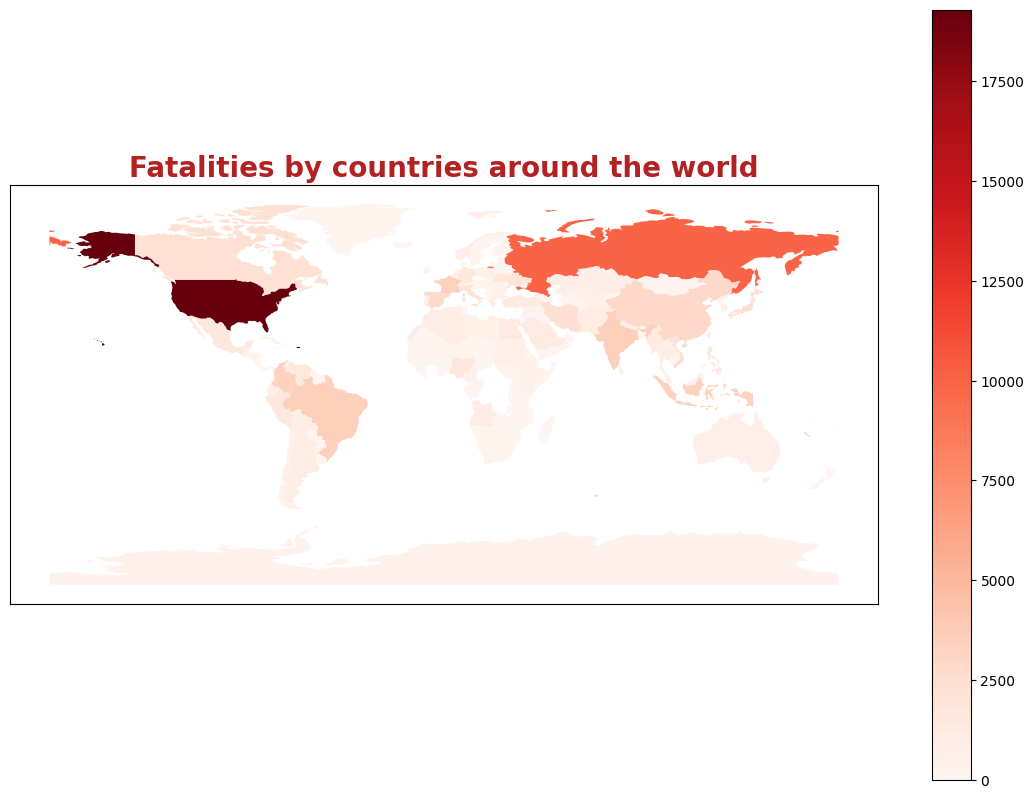

In [ ]:
# Joining world map and disaster df
merged = world.merge(fatalities_by_country, how="left", left_on="countries_clean", right_on="country")

# Drawing Cartogram
plt.rcParams['figure.figsize'] = [14,10]
merged.plot(column="fatalities", legend=True, cmap="Reds")
plt.title("Fatalities by countries around the world", fontweight='bold', color='#b22222', fontsize=20)
plt.xticks([])
plt.yticks([])
plt.show()